In [1]:
import ROOT as r
import root_numpy as rn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import array as array
from xgboost import XGBClassifier
from tools.data_processing import *
from tools.select_and_fit_funct import select_and_fit, plot_MC_vs_data
import os

/home/hep/davide/miniconda3/envs/root_env/lib/ROOT.py:301: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return _orig_ihook( name, *args, **kwds )


In [2]:
#b = r.TBrowser()

# PATHs

In [3]:
test=1
l_index=0
trig_index=5
mother_index_fit=2


l_flv=['e','mu']
mother_ID=["Ds","Dplus","both"]
trig_cat=["Any","L0l_TOS","TISnotTOS","L0G_TIS","TISorTOS","TOSnotTIS","TOSandTIS"]


BDT_PATH=l_flv[l_index]+'/BDTs/test_'+str(test)
FIT_PATH=l_flv[l_index]+'/fits'
with open(BDT_PATH+'/variables_used.pickle', 'rb') as f:  
        branches_needed_0 = pickle.load(f)
        
branches_needed_BDT=['cos_thetal']+branches_needed_0
branches_old = ['cos_thetal'] + return_branches(data_index=1,mother_index=0,l_index=l_index,meson_index=0)
branches=[]
for label in branches_old:
    if 'NDOF' not in label:
        branches.append(label)

# Data loading, applying mass cuts, preprocessing

14942
(13679, 1155, 1280)


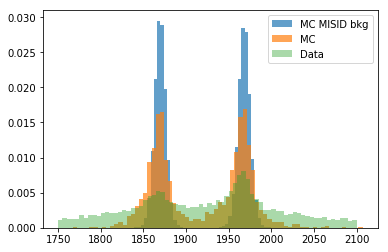

In [4]:
#MC_Dplus_sig_dict, MC_Ds_sig_dict, _ = load_datasets(l_index)
"""
Data

"""
if l_flv[l_index]=='e' and trig_cat[trig_index]!='Any':
    with open('/disk/lhcb_data/davide/Rphipi/data_for_BDT_selection/'+l_flv[l_index]+l_flv[l_index]+'/TrigCats/data_for_BDT_selection_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
        data_dict=pickle.load(f)
        
#    with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/TrigCats/'+l_flv[l_index]+l_flv[l_index]+'/'+'MC_Dplus_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
#        MC_Dplus_tuple_dict=pickle.load(f)
#        
#    with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/TrigCats/'+l_flv[l_index]+l_flv[l_index]+'/'+'MC_Ds_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
#        MC_Ds_tuple_dict=pickle.load(f)
    
elif l_flv[l_index]=='e' and trig_cat[trig_index]=='Any':
    with open('/disk/lhcb_data/davide/Rphipi/data_for_BDT_selection/'+l_flv[l_index]+l_flv[l_index]+'/'+'data_for_BDT_selection_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'rb') as f:
        data_dict=pickle.load(f)
        
if l_flv[l_index]=='mu' and trig_cat[trig_index]!='Any':
    with open('/disk/lhcb_data/davide/Rphipi/data_for_BDT_selection/'+l_flv[l_index]+l_flv[l_index]+'/TrigCats/data_for_BDT_selection_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
        data_dict=pickle.load(f)
        
#    with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/TrigCats/'+l_flv[l_index]+l_flv[l_index]+'/'+'MC_Dplus_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
#        MC_Dplus_tuple_dict=pickle.load(f)
#        
#    with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/TrigCats/'+l_flv[l_index]+l_flv[l_index]+'/'+'MC_Ds_'+l_flv[l_index]+l_flv[l_index]+'_'+trig_cat[trig_index]+'.pickle', 'rb') as f:
#        MC_Ds_tuple_dict=pickle.load(f)
    
elif l_flv[l_index]=='mu' and trig_cat[trig_index]=='Any':
    with open('/disk/lhcb_data/davide/Rphipi/data_for_BDT_selection/'+l_flv[l_index]+l_flv[l_index]+'/'+'data_for_BDT_selection_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'rb') as f:
        data_dict=pickle.load(f)

print(data_dict["Ds_ConsD_M"].shape[0])
"""
MC signal

"""    

with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/'+l_flv[l_index]+l_flv[l_index]+'/MC_'+mother_ID[1]+'_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'rb') as f:
    MC_Dplus_tuple_dict=pickle.load(f)
with open('/disk/lhcb_data/davide/Rphipi/MC/for_fit/'+l_flv[l_index]+l_flv[l_index]+'/MC_'+mother_ID[0]+'_'+l_flv[l_index]+l_flv[l_index]+'.pickle', 'rb') as f:
    MC_Ds_tuple_dict=pickle.load(f)

"""
MC MISID bkg

""" 

mc_Ds_MISID_mass=rn.root2array(
        
        filenames="/disk/lhcb_data/davide/Rphipi/MC/mc_MISID/"+l_flv[l_index]+l_flv[l_index]+"/"+mother_ID[0]+"23pi_"+l_flv[l_index]+"MISID.root",
        treename = 'DecayTree',
        branches = 'Dsp_0_M',
    )*1000

mc_Dplus_MISID_mass=rn.root2array(
        
        filenames="/disk/lhcb_data/davide/Rphipi/MC/mc_MISID/"+l_flv[l_index]+l_flv[l_index]+"/"+mother_ID[1]+"23pi_"+l_flv[l_index]+"MISID.root",
        treename = 'DecayTree',
        branches = 'Dp_0_M',
    )*1000

"""
Normalising the chi2s in data and MC

"""

MC_Dplus_tuple_dict, MC_Ds_tuple_dict, data_dict = norm_chi2(MC_Dplus_tuple_dict, MC_Ds_tuple_dict, data_dict)


"""
Applying mass cuts on data, 
retrieving mass distributions for sig MC and data

"""

if l_index==1:
    if mother_index_fit==0:
        #fitting only the Ds
        lower_cut=1930
        upper_cut=2010
    if mother_index_fit==1:
        #fitting only the Dplus
        lower_cut=1860
        upper_cut=1880
    if mother_index_fit==2:
        lower_cut=1820
        upper_cut=2040

if l_index==0:
    if mother_index_fit==0:
        #fitting only the Ds
        lower_cut=1900
        upper_cut=2040
    if mother_index_fit==1:
        #fitting only the Dplus
        lower_cut=1820
        upper_cut=1920
    if mother_index_fit==2:
        lower_cut=1750
        upper_cut=2100
        
        
data_mass, mc_Dplus_mass, mc_Ds_mass, data_dict = mass_cut_for_fit(lower_cut, upper_cut, mother_index_fit=mother_index_fit, l_index=l_index,
                                                 branches_needed=branches_needed_BDT, 
                                                 data_dict=data_dict, MC_Dplus_dict=MC_Dplus_tuple_dict, MC_Ds_dict=MC_Ds_tuple_dict)


"""
Preprocessing

"""



data_to_select, mc_Dplus_to_select, mc_Ds_to_select = preprocess_for_XGBoost(MC_Dplus_tuple_dict, MC_Ds_tuple_dict, data_dict, branches_needed_BDT, mother_index_fit=mother_index_fit)


plt.hist(np.concatenate((mc_Dplus_MISID_mass, mc_Ds_MISID_mass)),bins=70,density=True,alpha=0.7,label="MC MISID bkg");
plt.hist(np.concatenate((mc_Dplus_mass, mc_Ds_mass)),bins=70,density=True,alpha=0.7,label="MC");
plt.hist(data_mass,bins=70,density=True,alpha=0.4,label="Data");
plt.legend();


# Just RooFit it!

In [5]:
#Just fit it!

#if __name__=='__main__':

  # parser = argparse.ArgumentParser(description='Fit at different BDT cuts')
  # parser.add_argument('-x_cut', metavar='BDT cut', type =float, help='BDT cut')
  # args = parser.parse_args()
    
x_cut_values = np.linspace(0.01,0.99,num=20)
data={}
MC_Dplus={}
MC_Ds={}
fit_results={}
#Just fit it!
for i, x_cut in enumerate(x_cut_values[1:2]):
    
    if not os.path.exists(FIT_PATH+'/'+mother_ID[mother_index_fit]+'/{0}/'.format(i)):
        os.mkdir(FIT_PATH+'/'+mother_ID[mother_index_fit]+'/{0}/'.format(i))
    
    fit_results[i], data[i], MC_Dplus[i], MC_Ds[i] = select_and_fit(BDT_PATH, mother_index_fit, l_index, trig_index, lower_cut, upper_cut,
                                               data_mass, mc_Dplus_mass, mc_Ds_mass, mc_Dplus_MISID_mass, mc_Ds_MISID_mass,
                                               data_to_select, mc_Dplus_to_select, mc_Ds_to_select,
                                               data_dict, MC_Dplus_tuple_dict, MC_Ds_tuple_dict, branches_needed_BDT, branches, 
                                               x_cut, i, test, plots=True)
    if l_flv[l_index]=='mu':
        with open(FIT_PATH+'/'+mother_ID[mother_index_fit]+'/{0}/fit_results_{1}.txt'.format(i, i), 'w') as f:
            print('Saving fit results...')
            for key, value in fit_results[i].items():
                f.write('%s:%s\n' % (key, value))
                
    elif l_flv[l_index]=='e' and trig_cat[trig_index]=='Any':
        with open(FIT_PATH+'/'+mother_ID[mother_index_fit]+'/{0}/fit_results_{1}.txt'.format(i, i), 'w') as f:
            print('Saving fit results...')
            for key, value in fit_results[i].items():
                f.write('%s:%s\n' % (key, value))
    elif l_flv[l_index]=='e' and trig_cat[trig_index]!='Any':
        with open(FIT_PATH+'/'+mother_ID[mother_index_fit]+'/{0}'.format(i)+'/TrigCats/'+trig_cat[trig_index]+'/fit_results_{0}.txt'.format(i), 'w') as f:
            print('Saving fit results...')
            for key, value in fit_results[i].items():
                f.write('%s:%s\n' % (key, value))

BDT cut at 0.0615789473684 fit
BDT selection..
(499, 474)
BDT Signal selection efficiency: 0.399589322382
chi2 0.747467122077
Saving fit results...


<BarContainer object of 9 artists>

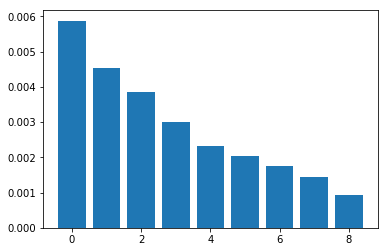

In [23]:
plt.bar(range(9),[fit_results[i]["punzi_fom"] for i in range(9)])

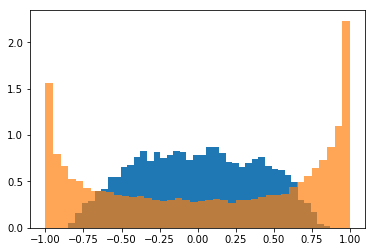

In [8]:
plt.hist(data[0]["cos_thetal"],density=True,bins=40);
plt.hist(data_dict["cos_thetal"],alpha=0.7,density=True,bins=40);

In [21]:
iteration=0
variable="Ds_ConsD_M"

variable_MC_Ds=variable
variable_MC_Dplus=variable_MC_Ds.replace("Ds","Dplus")

inf=data[iteration][variable].min()
sup=data[iteration][variable].max()

data_entries=data[iteration][variable].shape[0]

mc_Ds_entries=MC_Ds[iteration][variable_MC_Ds].shape[0]
mc_Dplus_entries=MC_Dplus[iteration][variable_MC_Dplus].shape[0]

f=r.TFile("test.root","RECREATE")
t=r.TTree("histo","histo")

data_hist = r.TH1F("sWeighted data "+ variable, 
                   "sWeighted data "+ variable, 
                   70,inf,sup)
data_hist.Sumw2()

mc_hist = r.TH1F("MC "+ variable, 
                 "MC "+ variable, 
                   70,inf,sup)
mc_hist.Sumw2()

for i in range(data_entries):
    data_hist.Fill(data[iteration][variable][i],data[iteration]["nDs_sw"][i])
        
for i in range(mc_Ds_entries):    
    mc_hist.Fill(MC_Ds[iteration][variable_MC_Ds][i])
    
for i in range(mc_Dplus_entries):    
    mc_hist.Fill(MC_Dplus[iteration][variable_MC_Dplus][i])


n1 = data_hist.Integral("width") 
data_hist.Scale(1/n1)
n2 = mc_hist.Integral("width")
mc_hist.Scale(1/n2)


In [23]:
data_hist.Draw("E")
#mc_hist.Draw("E Same")
data_hist.GetXaxis().SetTitle(variable)
data_hist.GetYaxis().SetTitleOffset(1.5)
data_hist.GetYaxis().SetTitle("distr dN/d"+variable)
data_hist.SetLineColor(r.kRed)
r.gStyle.SetOptStat("11")
legend = r.TLegend(0.89, 0.89, 0.75, 0.8)
legend.AddEntry(data_hist,"data","f")
legend.AddEntry(mc_hist,"mc","f")
legend.Draw()

In [ ]:
#for variable in branches_needed:
#
#    plot_MC_vs_data(data_cut, data_weights, MC_Ds_cut, 
#                variable, 
#                sw_idx=sw_idx, l_index=l_index, mother_index_fit=mother_index_fit)
#plt.hist(data_cut["cos_thetal"], weights=data_weights_Ds, density=True,
#         histtype='step', hatch='/', fill='True', linewidth='2', 
#         alpha=0.65,  bins=70, label='Weighted data Cos(theta_l)');
#
#plt.hist(MC_Ds_cut["cos_thetal"],density=True, 
#         histtype='step', hatch='\\', fill='True', linewidth='2', 
#         alpha=0.45, bins=70, label='MC Ds Cos(theta_l)');
#plt.legend(fontsize=12)
#fig=plt.gcf()
#fig.set_size_inches(10,6)

In [ ]:
#sw_data_array= np.array( 
#                           [
#                           tuple( data[label][k] for label in branches+["nDplus_sw","nDs_sw"] )
#                               
#                           for k in range(s_weights[0]["nDplus_sw"].shape[0])
#                           ],
#    
#                           dtype=[(label, np.float32) for label in branches+["nDplus_sw","nDs_sw"]]
#    
#                         )
# rn.array2root(sw_data_array,
#                      filename='/disk/lhcb_data/davide/Rphipi/BDT_selected_data/'+l_flv[l_index]+l_flv[l_index]+'/sw_data_'+l_flv[l_index]+l_flv[l_index]+'.root',
#                      treename='decay_tree',
#                      mode='recreate',
#                     )